# SMA Analysis | Application of Parseval's Theorem and Filtering in Selecting SMA Lengths

This notebook briefly demonstrates how simple moving average length selection could be automated. Since moving averages are low-pass filters- and given the relationship between their lengths and cutoff frequency -parsevals theorem can be used to identify the band of frequencies that contain a desired signal energy and select the appropriate moving average length. Since simple moving averages serve the purpose of approximating a signal, this band should contain as much signal energy as possible to minimize the mean squared error of the moving average approximation. 

In [281]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.fft as fft
import scipy.signal as signal
from scipy.linalg import norm 
from scipy.signal import TransferFunction as tf

import yfinance as yf

#PROGRAM PARAMETERS
FFTLEN = 10000 #length of fft
START = -500 #start candle of stock prices
END = -1 #end candle of stock prices
EP = 90 #percent energy to be conserved
N = 15 #butterworth filter order


## Loading Data

The Yahoo Finance API is used to download AAPL stock data. This data is then placed into a Numpy array and cropped to make calculations easier. Non-zero initial conditions are then removed. These initial conditions are added back to the data after it is filtered.

[*********************100%***********************]  1 of 1 completed


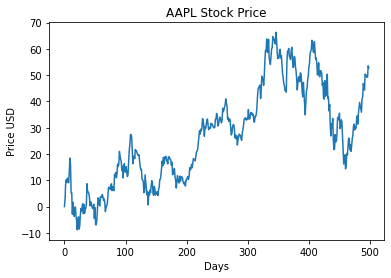

In [282]:
aapl = yf.download("AAPL", period = "max") #downloading AAPL data from yahoo finance
stock_prices = np.array(aapl["Close"]) #putting the close price data into a 1D numpy array
data = stock_prices[START:END] #cropping the data to make it easier to work with
initial_conditions = data[0] #accounting for non-zero, constant initial conditions
data -= initial_conditions #^^^

plt.figure()
plt.title("AAPL Stock Price")
plt.xlabel('Days')
plt.ylabel('Price USD')
plt.plot(data)

## Applying Parseval's Theorem

Welch's method is used to generate a power density spectrum of the stock price signal. Parseval's theorem is then used to identify the frequency band that contains the desired amount of signal energy. The power density spectrum is normalized to simplify this calculation to be a simple summation of the power values of the power density spectrum, where the total area under the power density spectrum curve is 100% of the energy. 

The power density spectrum plot can be used to visualize how much of the energy is conserved, which is less ambiguous than trial and error with various moving average lengths etc.  

Note how the vast majority of the energy is at lower frequencies. This is because the majority of the signal energy contributes to the trend, and a minority contributes to volatility. This is also consistent with the idea that trading at high frequencies is riskier than trading at low frequencies. 

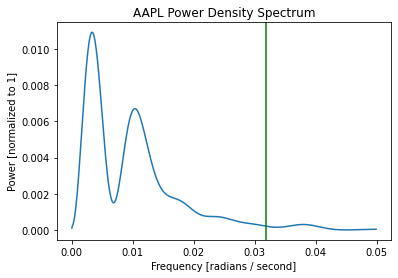

In [283]:

#finds the frequency band that contains the given energy
def find_band(Pxx, E):
    n = 0 #counter
    En = 0 #summation
    while En < E:
        En += Pxx[n]
        n += 1
    return n #index of energy frequency band
    
Ep = EP/100.0 #convert percent to decimal
freqs, psd = signal.welch(data, nfft=FFTLEN) #generating power spectrum in frequency domain
psd = psd/norm(psd, 1) #normalizing power spectrum to simplify calculations
band = freqs[find_band(psd, Ep)] #finding frequency band that contains desired amount of energy

plt.figure()
plt.title("AAPL Power Density Spectrum")
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Power [normalized to 1]')
PSDEND = 500 #plot this many elements of the psd
plt.plot(freqs[:PSDEND], psd[:PSDEND]) #plot the power spectrum (zoomed in)
plt.axvline(band, color='green') #show energy band

## Butterworth Filter

A Butterworth filter with a cutoff frequency equal to the band found previously is used to filter the price signal.

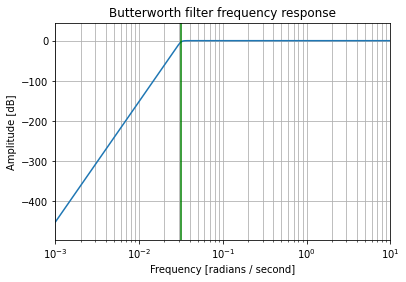

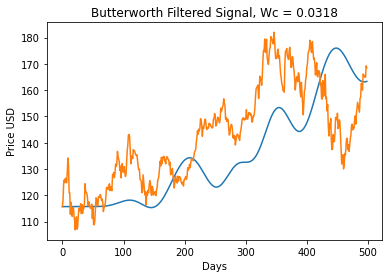

In [284]:
b, a = signal.butter(N, band, 'high', 'ba') #generate butterworth LPF with cutoff at energy band
w, h = signal.freqs(b, a, len(freqs)) #generate frequency response data

#Bode plot 
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(band, color='green') # cutoff frequency
plt.show()

sos = signal.butter(N, band, 'low', output='sos') #generate second order sections of butterworth filter
filtered = signal.sosfilt(sos, data) #generate time domain response of butterworth filter

#plot filtered signal
plt.figure()
plt.title("Butterworth Filtered Signal, Wc = {}".format(band))
plt.xlabel('Days')
plt.ylabel('Price USD')
plt.plot(filtered + initial_conditions)
plt.plot(data + initial_conditions)



## Moving Average Filter

A moving average filter with a cutoff frequency equivalent to the band found earlier is created. This filter is implemented in the time domain, so the length of the moving average is found using an approximation- courtesy of stack overflow -given the cutoff frequency. 

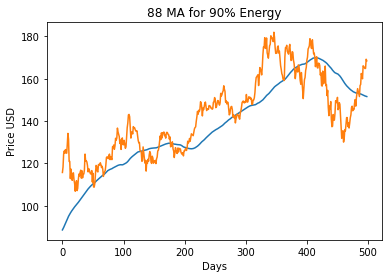

In [285]:
L = round(np.sqrt(0.196202+(band/(2*np.pi))**2)/(band/(2*np.pi))) #approximating L required to create a moving average filter with cutoff at energy band
stock_sma = np.array(aapl["Close"].rolling(L).mean())[START:END] #generate np array of moving average with length L

plt.figure()
plt.title("{} MA for {}% Energy".format(L, EP))
plt.xlabel('Days')
plt.ylabel('Price USD')
plt.plot(stock_sma)
plt.plot(data + initial_conditions)